# Case Study

The data for this case study comes from the paper

```Andreoni, J., & Samuelson, L. (2006). Building rational cooperation. Journal of economic theory, 127(1), 117-154.```

The data can be downloaded from the supplementary materials of the following [paper](https://doi.org/10.3982/QE1744):

```Bojinov, I., Rambachan, A., & Shephard, N. (2021). Panel experiments and dynamic causal effects: A finite population perspective. Quantitative Economics, 12(4), 1171-1196.```

We use a modified version that consolidates all tabs.

## Imports

In [1]:
from shared.simulators import ConstantEffectSimulator, ModeratedEffectSimulator, DataSimulator, EffectSimulatorCollection
from shared.analyzers import IPWAnalyzer, SIPWAnalyzer, MetaAnalyzer
from shared.ragged_analyzers import RaggedIPWAnalyzer, RaggedSIPWAnalyzer, RaggedMetaAnalyzer
from shared.result_processors import Results
from shared.config_plt import config_plt, get_fig_ax, save_my_fig
from tqdm import trange
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import copy

config_plt()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Preprocessing

In [2]:
# Read in data and add columns
df = pd.read_excel("cooperation.xlsx", sheet_name="Consolidated")
df["x_above_5"] = df["x"] > 5
df["p_x_above_5"] = 5/11
df["x_3_to_7"] = (3 <= df["x"]) & (df["x"] <= 7)
df["p_x_3_to_7"] = 5/11
df["one"] = 1
df["coop1"] = df["decision1"] == "PUSH"
df["coop2"] = df["decision2"] == "PUSH"
df["total_coop"] = df["coop1"].astype(float) + df["coop2"].astype(float)

In [3]:
# Deduplicate
df_deduped = df[~df["is_duplicate"]]

# Separate by round
df_round1 = df_deduped[df_deduped["round"] == 1]
df_round2 = df_deduped[df_deduped["round"] == 2]

# Sum accross rounds
merge_columns = ['batch', 'game', 'id1', 'id2', 'is_duplicate', '3x', 'x', 'x_above_5', 'p_x_above_5', 'x_3_to_7', 'p_x_3_to_7', 'one']
df_round_sums = pd.merge(df_round1, df_round2, how="inner", on=merge_columns, suffixes=("_r1", "_r2"))

df_round_sums["coop_sum1"] = df_round_sums["coop1_r1"].astype(float) + df_round_sums["coop1_r2"].astype(float)
df_round_sums["coop_sum2"] = df_round_sums["coop2_r1"].astype(float) + df_round_sums["coop2_r2"].astype(float)
df_round_sums["total_coop"] = df_round_sums["total_coop_r1"] + df_round_sums["total_coop_r2"]
df_round_sums["earnings1"] = df_round_sums["earnings1_r1"] + df_round_sums["earnings1_r2"]
df_round_sums["earnings2"] = df_round_sums["earnings2_r1"] + df_round_sums["earnings2_r2"]
df_round_sums["total_earnings"] = df_round_sums["total_earnings_r1"] + df_round_sums["total_earnings_r2"]

df_round_sums["push_then_pull1"] = (df_round_sums["coop1_r1"]) & (~df_round_sums["coop1_r2"])
df_round_sums["push_then_pull2"] = (df_round_sums["coop2_r1"]) & (~df_round_sums["coop2_r2"])
df_round_sums["total_push_then_pull"] = df_round_sums["push_then_pull1"].astype(float) + df_round_sums["push_then_pull2"].astype(float)

df_round_sums["pull_then_push1"] = (~df_round_sums["coop1_r1"]) & (df_round_sums["coop1_r2"])
df_round_sums["pull_then_push2"] = (~df_round_sums["coop2_r1"]) & (df_round_sums["coop2_r2"])
df_round_sums["total_pull_then_push"] = df_round_sums["pull_then_push1"].astype(float) + df_round_sums["pull_then_push2"].astype(float)

df_round_sums["push_then_push1"] = (df_round_sums["coop1_r1"]) & (df_round_sums["coop1_r2"])
df_round_sums["push_then_push2"] = (df_round_sums["coop2_r1"]) & (df_round_sums["coop2_r2"])
df_round_sums["total_push_then_push"] = df_round_sums["push_then_push1"].astype(float) + df_round_sums["push_then_push2"].astype(float)

df_round_sums["pull_then_pull1"] = (~df_round_sums["coop1_r1"]) & (~df_round_sums["coop1_r2"])
df_round_sums["pull_then_pull2"] = (~df_round_sums["coop2_r1"]) & (~df_round_sums["coop2_r2"])
df_round_sums["total_pull_then_pull"] = df_round_sums["pull_then_pull1"].astype(float) + df_round_sums["pull_then_pull2"].astype(float)

In [4]:
# Create ID-level data
df_id1_round_sums = df_round_sums.copy()
df_id1_round_sums["batch:id"] = df_id1_round_sums["batch"].astype(str) + ":" + df_id1_round_sums["id1"].astype(str)
df_id1_round_sums["coop_sum"] = df_id1_round_sums["coop1_r1"].astype(float) + df_id1_round_sums["coop1_r2"].astype(float)
df_id1_round_sums["earnings_sum"] = df_id1_round_sums["earnings1_r1"] + df_id1_round_sums["earnings1_r2"]
df_id2_round_sums = df_round_sums.copy()
df_id2_round_sums["batch:id"] = df_id2_round_sums["batch"].astype(str) + ":" + df_id2_round_sums["id2"].astype(str)
df_id2_round_sums["coop_sum"] = df_id2_round_sums["coop2_r1"] + df_id2_round_sums["coop2_r2"]
df_id2_round_sums["earnings_sum"] = df_id2_round_sums["earnings2_r1"] + df_id2_round_sums["earnings2_r2"]
df_ids_round_sums = pd.concat([df_id1_round_sums, df_id2_round_sums], axis=0).sort_values(by="batch:id")

In [5]:
# Join in outcomes from previous games
dfx_columns = [
    "batch",
    "game",
    "id",
    "x",
    "x_above_5",
    "decision_r1",
    "decision_r2",
    "coop_sum",
    "earnings_r1",
    "earnings_r2",
    "earnings"
]
df1 = df_round_sums.copy().rename({
    "id1": "id",
    "decision1_r1": "decision_r1",
    "decision1_r2": "decision_r2",
    "coop_sum1": "coop_sum",
    "earnings1_r1": "earnings_r1",
    "earnings1_r2": "earnings_r2",
    "earnings1": "earnings",
}, axis=1)[dfx_columns]
df2 = df_round_sums.copy().rename({
    "id2": "id",
    "decision2_r1": "decision_r1",
    "decision2_r2": "decision_r2",
    "coop_sum2": "coop_sum",
    "earnings2_r1": "earnings_r1",
    "earnings2_r2": "earnings_r2",
    "earnings2": "earnings",
}, axis=1)[dfx_columns]
df_individual = pd.concat([df1, df2], axis=0)
df_individual["game_lead1"] = df_individual["game"] + 1
df_individual1 = df_individual.rename(lambda x: f"{x}_p1", axis=1)
df_individual2 = df_individual.rename(lambda x: f"{x}_p2", axis=1)
df_lag = pd.merge(
    df_round_sums, df_individual1, how="left", 
    left_on=["batch", "game", "id1"], right_on=["batch_p1", "game_lead1_p1", "id_p1"])
df_lag = pd.merge(
    df_lag, df_individual2, how="left",
    left_on=["batch", "game", "id2"], right_on=["batch_p2", "game_lead1_p2", "id_p2"])
df_lag = df_lag[df_lag["game"] >= 2]
df_lag["last_game_avg_earnings"] = (df_lag["earnings_p1"] + df_lag["earnings_p2"]) / 2.
df_lag["last_game_coop_sum"] = df_lag["coop_sum_p1"] + df_lag["coop_sum_p2"]
df_lag["last_game_x_above_5"] = df_lag["x_above_5_p1"].astype(float) + df_lag["x_above_5_p2"].astype(float)
df_lag["last_game_avg_x"] = (df_lag["x_p1"] + df_lag["x_p2"]) / 2.

In [6]:
# Create dataframe with multiple thresholds
df_thresholds = df_lag.copy()
df_thresholds["x_threshold"] = 0
for i in range(1, 10):
    df_threshold_i = df_lag.copy()
    df_threshold_i["x_threshold"] = i
    df_thresholds = pd.concat([df_thresholds, df_threshold_i], axis=0)
df_thresholds = df_thresholds.reset_index()
df_thresholds["x_above_threshold"] = df_thresholds["x"] > df_thresholds["x_threshold"]
df_thresholds["p_x_above_threshold"] = (10. - df_thresholds["x_threshold"]) / 11.

## Helper Functions

In [7]:
def get_spline_Xs(x, degree=3):
    X = np.ones((x.size, degree+1))
    x_plot = np.linspace(x.min(), x.max())
    X_plot = np.ones((x_plot.size, degree+1))
    for d in range(degree+1):
        X[:, d] = x**d
        X_plot[:, d] = x_plot**d
    return X, x_plot, X_plot

def fit_spline_and_plot(model_df, id_col, moderator_col, treatment_col, prob_col, outcome_col, degree=3, ax=None, label=None):
    # Fit model
    x = model_df[moderator_col]
    X, x_plot, X_plot = get_spline_Xs(x, degree=degree)
    ragged_analyzer = RaggedIPWAnalyzer(
        name="IPW", dr=True, robust=True,
        id_col=id_col, treatment_col=treatment_col,
        prob_col=prob_col, outcome_col=outcome_col)
    ragged_analyzer.fit(model_df, X)

    # Plot results
    plot_estimates = X_plot @ ragged_analyzer.estimates[0]
    plot_vars = ((X_plot @ ragged_analyzer.estimates_cov[0]) * X_plot).sum(axis=1)
    plot_ses = np.sqrt(plot_vars)
    z = 1.96
    plot_lower = plot_estimates - z * plot_ses
    plot_upper = plot_estimates + z * plot_ses

    if ax is None:
        fig, ax = get_fig_ax()
    ax.fill_between(x_plot, plot_lower, plot_upper, alpha=0.1)
    ax.plot(x_plot, plot_estimates, label=label)
    ax.axhline(0, color="gray", linewidth=1, linestyle=":")
    if label is not None:
        ax.legend()
    return ragged_analyzer

In [8]:
def fit_separate_and_plot(model_df, id_col, treatment_col, prob_col, outcome_col, by_batch=False, plot_diffs=False, ax=None, label=None):
    # Fit model
    X = model_df["one"].values.reshape((-1, 1))
    ragged_analyzer = RaggedIPWAnalyzer(
        name="IPW", dr=True, robust=True,
        id_col=id_col, treatment_col=treatment_col,
        prob_col=prob_col, outcome_col=outcome_col)
    ragged_analyzer.fit(model_df, X)
    
    # Plot results
    plot_estimates = ragged_analyzer.estimates[:, 0]
    plot_vars = ragged_analyzer.estimates_cov[:, 0, 0]
    plot_ses = np.sqrt(plot_vars)
    z = 1.96
    plot_errors = z * plot_ses
        
    plot_df = pd.DataFrame({
        "batch": pd.Series(ragged_analyzer.unique_ids).astype(str).str[0].astype(int),
        "id": ragged_analyzer.unique_ids,
        "estimate": plot_estimates,
        "var": plot_vars,
        "se": plot_ses,
        "error": plot_errors})

    if plot_diffs:
        plot_df["diff"] = ragged_analyzer.estimates[:, 0] - ragged_analyzer.estimates[0, 0]
        plot_df["diff_var"] = diff_vars = ragged_analyzer.estimates_cov[:, 0, 0] + ragged_analyzer.estimates_cov[0, 0, 0]
        plot_df["diff_se"] = np.sqrt(plot_df["diff_var"])
        plot_df["diff_error"] = z * plot_df["diff_se"]

    plot_df = plot_df.sort_values(by=["batch", "estimate"]).reset_index(drop=True)
    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(0, color="gray", linewidth=1, linestyle=":")
    if by_batch:
        for b in range(1, 6):
            plot_df_b = plot_df[plot_df["batch"] == b]
            ax.errorbar(x=plot_df_b.index, y=plot_df_b["estimate"], yerr=plot_df_b["error"], label=b)
            if plot_diffs:
                ax.errorbar(x=plot_df_b.index+.1, y=plot_df_b["diff"], yerr=plot_df_b["diff_error"], label=f"{b}: Diff")
        if label is not None:
            ax.legend(title=label)
    else:
        ax.errorbar(x=plot_df.index, y=plot_df["estimate"], yerr=plot_df["error"], label="Raw" if plot_diffs else None)
        if plot_diffs:
            ax.errorbar(x=plot_df.index+.1, y=plot_df["diff"], yerr=plot_df["diff_error"], label="Difference")
            ax.legend(title=label)
    return ragged_analyzer

## Analysis

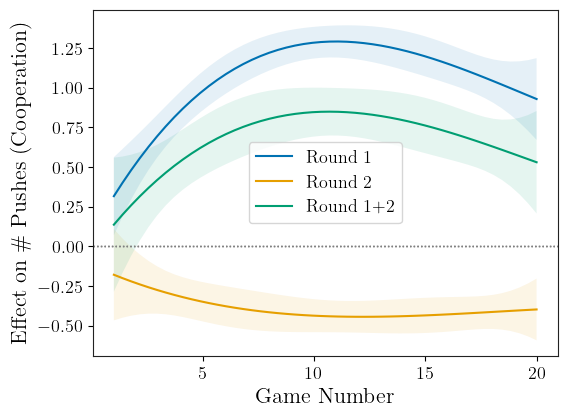

In [9]:
fig, ax = get_fig_ax((6, 4.5))
fit_spline_and_plot(df_round1, "one", "game", "x_above_5", "p_x_above_5", "total_coop", degree=3, ax=ax, label="Round 1")
fit_spline_and_plot(df_round2, "one", "game", "x_above_5", "p_x_above_5", "total_coop", degree=3, ax=ax, label="Round 2")
fit_spline_and_plot(df_round_sums, "one", "game", "x_above_5", "p_x_above_5", "total_coop", degree=3, ax=ax, label="Round 1+2")
ax.set_xlabel("Game Number")
ax.set_ylabel("Effect on \\# Pushes (Cooperation)")
plt.show()

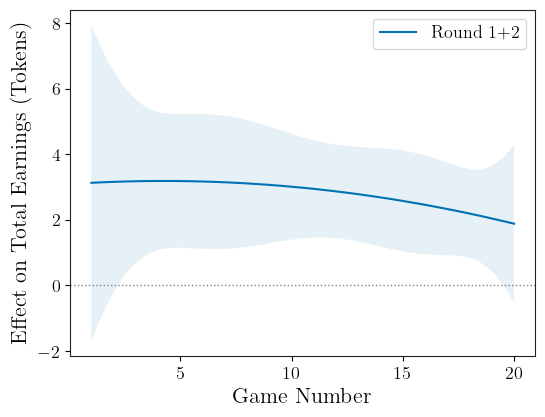

In [10]:
fig, ax = get_fig_ax((6, 4.5))
# fit_spline_and_plot(df_round1, "one", "game", "x_3_to_7", "p_x_3_to_7", "total_earnings", degree=3, ax=ax, label="Round 1")
# fit_spline_and_plot(df_round2, "one", "game", "x_3_to_7", "p_x_3_to_7", "total_earnings", degree=3, ax=ax, label="Round 2")
fit_spline_and_plot(df_round_sums, "one", "game", "x_3_to_7", "p_x_3_to_7", "total_earnings", degree=3, ax=ax, label="Round 1+2")
ax.set_xlabel("Game Number")
ax.set_ylabel("Effect on Total Earnings (Tokens)")
plt.show()

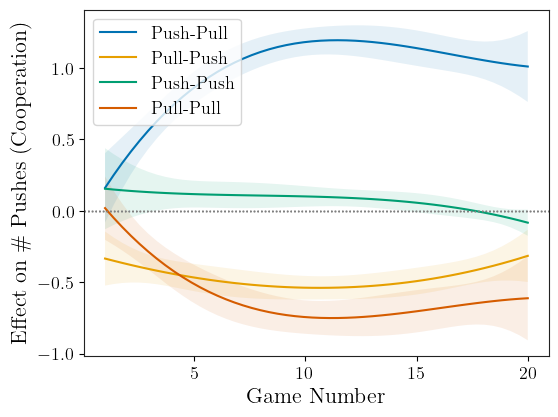

In [11]:
fig, ax = get_fig_ax((6, 4.5))
fit_spline_and_plot(df_round_sums, "one", "game", "x_above_5", "p_x_above_5", "total_push_then_pull", degree=3, ax=ax, label="Push-Pull")
fit_spline_and_plot(df_round_sums, "one", "game", "x_above_5", "p_x_above_5", "total_pull_then_push", degree=3, ax=ax, label="Pull-Push")
fit_spline_and_plot(df_round_sums, "one", "game", "x_above_5", "p_x_above_5", "total_push_then_push", degree=3, ax=ax, label="Push-Push")
fit_spline_and_plot(df_round_sums, "one", "game", "x_above_5", "p_x_above_5", "total_pull_then_pull", degree=3, ax=ax, label="Pull-Pull")
ax.set_xlabel("Game Number")
ax.set_ylabel("Effect on \\# Pushes (Cooperation)")
plt.show()

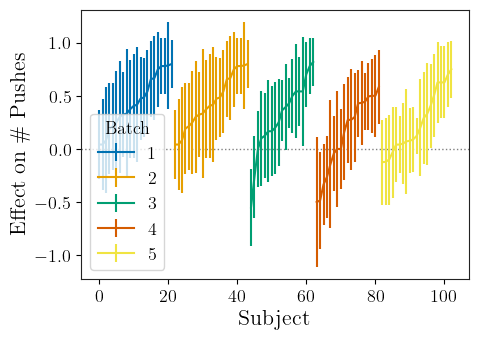

In [12]:
coop_props = df_ids_round_sums.groupby("batch:id")["coop_sum"].mean().sort_values()
included_batch_id = coop_props[coop_props < 1.].index
nonconstant_df = df_ids_round_sums[df_ids_round_sums["batch:id"].isin(included_batch_id)]
fig, ax = get_fig_ax()
fit_separate_and_plot(nonconstant_df, "batch:id", "x_above_5", "p_x_above_5", "coop_sum", by_batch=True, ax=ax, label="Batch")
ax.set_xlabel("Subject")
ax.set_ylabel("Effect on \\# Pushes")
plt.show()

P-value: 0.9497940007557332


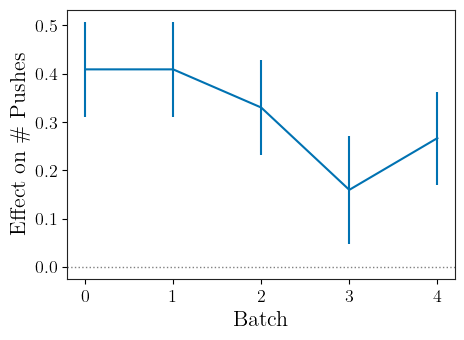

In [13]:
fig, ax = get_fig_ax()
batch_analyzer = fit_separate_and_plot(nonconstant_df, "batch", "x_above_5", "p_x_above_5", "coop_sum", by_batch=False, ax=ax, label="Batch")
ax.set_xlabel("Batch")
ax.set_ylabel("Effect on \\# Pushes")

batch_estimates = batch_analyzer.estimates[:, 0]
batch_vars = batch_analyzer.estimates_se[:, 0]
C = np.hstack([
    -np.ones((4, 1)),
    np.eye(4)])
S = C @ np.diag(batch_vars) @ C.T
z = np.linalg.cholesky(np.linalg.inv(S)) @ C @ batch_estimates
chi2_val = (z**2).sum()
chi2_pval = 1. - chi2.cdf(chi2_val, df=4)
print("P-value:", chi2_pval)

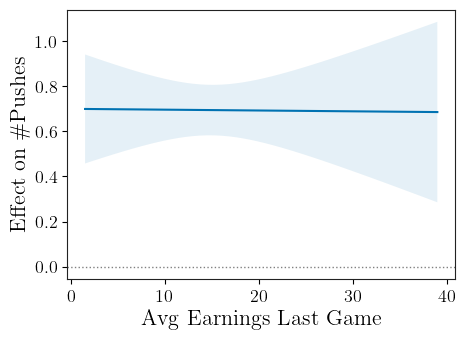

In [14]:
fig, ax = get_fig_ax()
fit_spline_and_plot(df_lag, "one", "last_game_avg_earnings", "x_above_5", "p_x_above_5", "total_coop", degree=1, ax=ax)
ax.set_xlabel("Avg Earnings Last Game")
ax.set_ylabel("Effect on \\#Pushes")
plt.show()

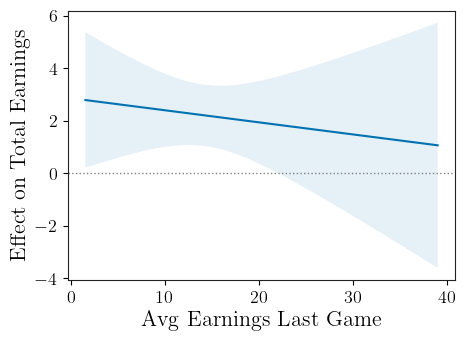

[[ 2.85844054 -0.04603901]]
[[1.44449471 0.09296009]]


In [15]:
fig, ax = get_fig_ax()
earnings_earnings_analyzer = fit_spline_and_plot(df_lag, "one", "last_game_avg_earnings", "x_above_5", "p_x_above_5", "total_earnings", degree=1, ax=ax)
ax.set_xlabel("Avg Earnings Last Game")
ax.set_ylabel("Effect on Total Earnings")
plt.show()
print(earnings_earnings_analyzer.estimates)
print(earnings_earnings_analyzer.estimates_se)

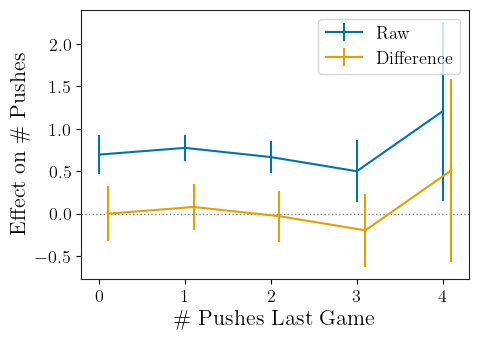

In [16]:
fig, ax = get_fig_ax()
last_pushes_analyzer = fit_separate_and_plot(df_lag, "last_game_coop_sum", "x_above_5", "p_x_above_5", "total_coop", plot_diffs=True, ax=ax)
ax.set_xlabel("\\# Pushes Last Game")
ax.set_ylabel("Effect on \\# Pushes")
plt.show()

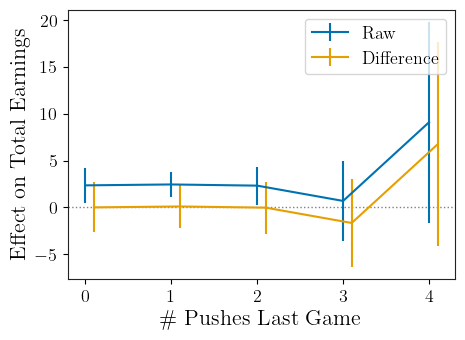

In [17]:
fig, ax = get_fig_ax()
last_pushes_analyzer = fit_separate_and_plot(df_lag, "last_game_coop_sum", "x_above_5", "p_x_above_5", "total_earnings", plot_diffs=True, ax=ax)
ax.set_xlabel("\\# Pushes Last Game")
ax.set_ylabel("Effect on Total Earnings")
plt.show()

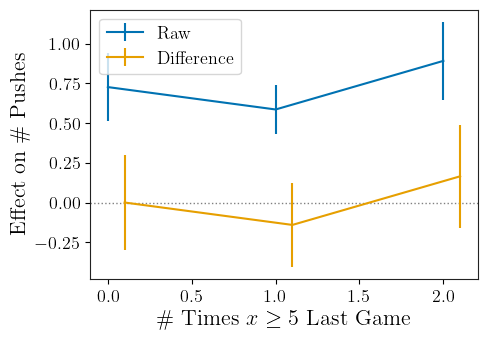

In [18]:
fig, ax = get_fig_ax()
fit_separate_and_plot(df_lag, "last_game_x_above_5", "x_above_5", "p_x_above_5", "total_coop", plot_diffs=True, ax=ax)
ax.set_xlabel("\\# Times $x \\geq 5$ Last Game")
ax.set_ylabel("Effect on \\# Pushes")
plt.show()

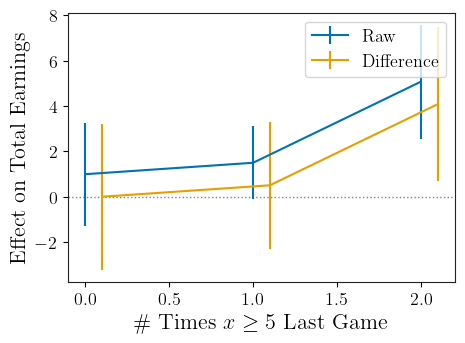

In [19]:
fig, ax = get_fig_ax()
fit_separate_and_plot(df_lag, "last_game_x_above_5", "x_above_5", "p_x_above_5", "total_earnings", plot_diffs=True, ax=ax)
ax.set_xlabel("\\# Times $x \\geq 5$ Last Game")
ax.set_ylabel("Effect on Total Earnings")
plt.show()

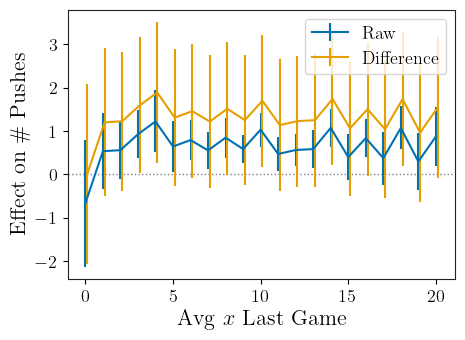

In [20]:
fig, ax = get_fig_ax()
fit_separate_and_plot(df_lag, "last_game_avg_x", "x_above_5", "p_x_above_5", "total_coop", plot_diffs=True, ax=ax)
ax.set_xlabel("Avg $x$ Last Game")
ax.set_ylabel("Effect on \\# Pushes")
plt.show()

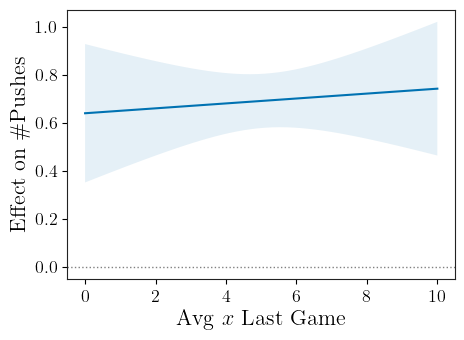

In [21]:
fig, ax = get_fig_ax()
fit_spline_and_plot(df_lag, "one", "last_game_avg_x", "x_above_5", "p_x_above_5", "total_coop", degree=1, ax=ax)
ax.set_xlabel("Avg $x$ Last Game")
ax.set_ylabel("Effect on \\#Pushes")
plt.show()

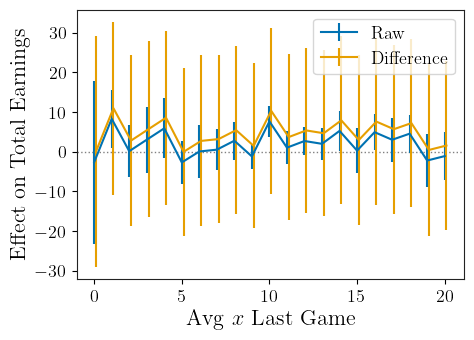

In [22]:
fig, ax = get_fig_ax()
fit_separate_and_plot(df_lag, "last_game_avg_x", "x_above_5", "p_x_above_5", "total_earnings", plot_diffs=True, ax=ax)
ax.set_xlabel("Avg $x$ Last Game")
ax.set_ylabel("Effect on Total Earnings")
plt.show()

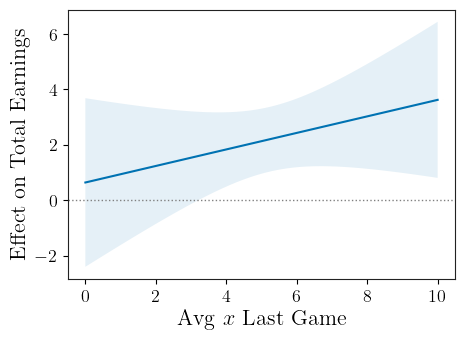

[[0.63832027 0.29812171]]
[[1.55184447 0.27403753]]


In [23]:
fig, ax = get_fig_ax()
x_earnings_analyzer = fit_spline_and_plot(df_lag, "one", "last_game_avg_x", "x_above_5", "p_x_above_5", "total_earnings", degree=1, ax=ax)
ax.set_xlabel("Avg $x$ Last Game")
ax.set_ylabel("Effect on Total Earnings")
plt.show()

print(x_earnings_analyzer.estimates)
print(x_earnings_analyzer.estimates_se)

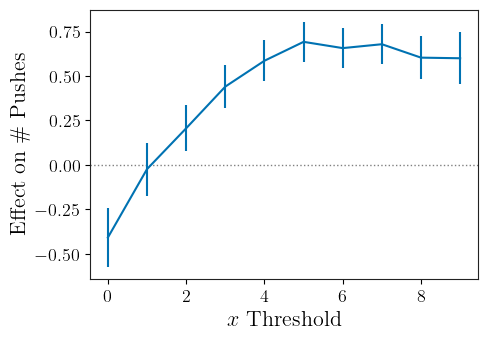

In [26]:
df_thresholds = df_lag.copy()
df_thresholds["x_threshold"] = 0
for i in range(1, 10):
    df_threshold_i = df_lag.copy()
    df_threshold_i["x_threshold"] = i
    df_thresholds = pd.concat([df_thresholds, df_threshold_i], axis=0)
df_thresholds = df_thresholds.reset_index()
df_thresholds["x_above_threshold"] = df_thresholds["x"] > df_thresholds["x_threshold"]
df_thresholds["p_x_above_threshold"] = (10. - df_thresholds["x_threshold"]) / 11.

fig, ax = get_fig_ax()
fit_separate_and_plot(df_thresholds, "x_threshold", "x_above_threshold", "p_x_above_threshold", "total_coop", plot_diffs=False, ax=ax)
ax.set_xlabel("$x$ Threshold")
ax.set_ylabel("Effect on \\# Pushes")
plt.show()

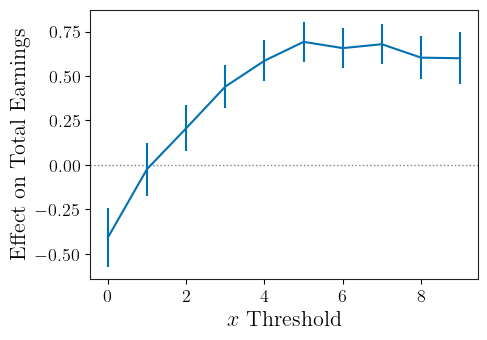

In [27]:
fig, ax = get_fig_ax()
fit_separate_and_plot(df_thresholds, "x_threshold", "x_above_threshold", "p_x_above_threshold", "total_coop", plot_diffs=False, ax=ax)
ax.set_xlabel("$x$ Threshold")
ax.set_ylabel("Effect on Total Earnings")
plt.show()

## Result Summary

1. There's clear moderation by game.
2. The causal effect varies by threshold, but it's pretty much constant after 5.
3. There's no moderation by other variables.

Questions:
- What other analyses should we do, if any?